# Exercício de Classificação de Análise de Sentimentos

O objetivo do exercício é explorar técnicas de pré-processamento de texto, como remoção de stopwords, tokenização e stemming, além de aplicar técnicas de vetorização, como Bag of Words (BoW) e Term Frequency-Inverse Document Frequency (TF-IDF) para classificar a polaridade de tweets em positivas ou negativas.

## Importar bibliotecas, carregar datasets, etc.

In [1]:
# importar bibliotecas basicas:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# bibliotecas complementares
import codecs
import nltk
import re
import spacy
import string
import unicodedata

# scikit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
# aleatoriedade controlada
random.seed(42)

In [3]:
# carregar dataset de treino
train = pd.read_csv('/kaggle/input/enap-anlise-de-sentimentos/train.csv', index_col=0)

## Pré analise

In [4]:
# Pré avaliação do dataset que está sendo carregado
print(train)

                                                      text  target
ID                                                                
1439813  @sweet19 thanksies but ur so lucky u are in hi...       4
621715                at the park playing tennis. i suck.        0
1188021               @tontokaru happy belated bday babe!        4
300651              @DxBLOCK  DM me your number again pls        0
757974                           Rest in Peace Ed McMahon        0
...                                                    ...     ...
1312263  @conc3p  &quot;I want him to watch&quot; + &qu...       4
143846                       @gershgorin that's awful!!!!        0
1253750  @HipMamaB LOL - I remember that episode!!  (wh...       4
134415                          @cooliesupreme I am sorry        0
1218280     @sesam not to worry, I don't use lifts either        4

[70000 rows x 2 columns]


Dá pra notar que tem muita 💩 no texto...
exemplos:
* uso de simbolos: @ ! ; + &
* girias: LOL DM bday ur
* erro de grafias: thanksies


In [5]:
train.dropna()
train.columns = ['text','target']
train.head()

,text,target
ID,,
1439813,@sweet19 thanksies but ur so lucky u are in hi...,4
621715,at the park playing tennis. i suck.,0
1188021,@tontokaru happy belated bday babe!,4
300651,@DxBLOCK DM me your number again pls,0
757974,Rest in Peace Ed McMahon,0


### Avaliação de distribuição das classes alvo

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


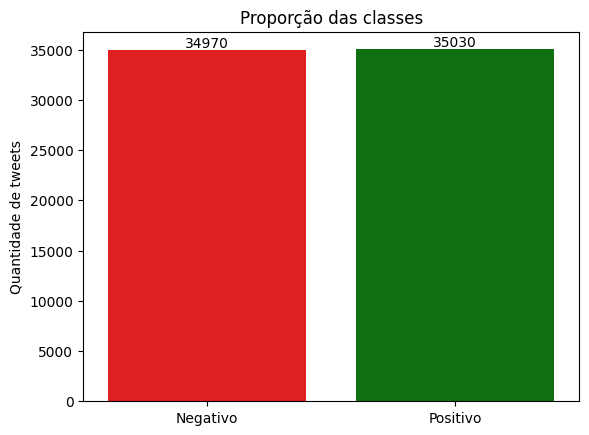

1.0017157563625965


In [6]:
# "extrair a quantidade de cada classe
Positive = train[train['target'] == 4].shape[0]
Negative = train[train['target'] == 0].shape[0]

# Definir os rótulos e valores das barras
labels = ['Negativo', 'Positivo']
values = [Negative, Positive]

# Definir as cores das barras
colors = ['red', 'green']

# Criar o gráfico de barras usando Seaborn
sns.barplot(x=labels, y=values, palette=colors)

# Adicionar rótulos às barras
for index, value in enumerate(values):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Adicionar rótulos dos eixos e título
plt.ylabel('Quantidade de tweets')
plt.title('Proporção das classes')

# Exibir o gráfico
plt.show()

rate = Positive/Negative
print(rate)

## Pre-processamento

### Limpeza do corpus de treinamento

In [7]:
'''texto em minúsculas, remova o texto entre colchetes, remova links, remova pontuações e remova palavras que contenham números.'''

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
train['text_clean'] = train['text'].apply(clean_text)
train.head()

,text,target,text_clean
ID,,,
1439813,@sweet19 thanksies but ur so lucky u are in hi...,4,thanksies but ur so lucky u are in high schoo...
621715,at the park playing tennis. i suck.,0,at the park playing tennis i suck
1188021,@tontokaru happy belated bday babe!,4,tontokaru happy belated bday babe
300651,@DxBLOCK DM me your number again pls,0,dxblock dm me your number again pls
757974,Rest in Peace Ed McMahon,0,rest in peace ed mcmahon


# Treinamento

In [9]:
X_train, y_train = train['text_clean'], train['target']

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X_train)

In [11]:
X_vectorized

<70000x74427 sparse matrix of type '<class 'numpy.int64'>'
	with 796400 stored elements in Compressed Sparse Row format>

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [13]:
nb_model = MultinomialNB()
nb_model.fit(X_vectorized, y_train)

MultinomialNB()

# Carga do dataset de Testes

In [14]:
X_test = pd.read_csv('/kaggle/input/enap-anlise-de-sentimentos/test.csv', index_col=0)

# X_test = X_test['text']
# Visualizar o dataframe
print(X_test.head())

                                                      text
ID                                                        
1432466  Advantage to being single, when yo're &quot;in...
986192   @twodesign :: Did you knock out the electricit...
485147   @PurplePyroPixie And within minutes of my prev...
1265743  @AshleyLobo you should have dropped off your c...
346809   UGH! I am sick and I have so much to do, inclu...


In [15]:
X_test['text'] = X_test['text'].apply(clean_text)

X_test.head()

,text
ID,
1432466,advantage to being single when yore quotin a m...
986192,twodesign did you knock out the electricity w...
485147,purplepyropixie and within minutes of my previ...
1265743,ashleylobo you should have dropped off your co...
346809,ugh i am sick and i have so much to do includi...


In [16]:
X_vectorized = vectorizer.transform(X_test)

In [17]:
X_vectorized

<1x74427 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [18]:
y_pred = nb_model.predict(X_vectorized)

In [19]:
y_pred

array([0])

In [20]:
pred = pd.DataFrame({'target': y_pred}, index=X_test.index)

print(pred)

         target
ID             
1432466       0
986192        0
485147        0
1265743       0
346809        0
...         ...
830710        0
27247         0
104191        0
185927        0
1576861       0

[30000 rows x 1 columns]


In [21]:
pred.to_csv('/kaggle/working/submission.csv')